# Optimize Ramp Settings

This notebook outlines an example to optimize the ramp settings for a few different types of observations.

In these types of optimizations, we must consider observations constraints such as saturation levels, SNR requirements, and limits on acquisition time.

**Note**: The reported acquisition time does not include obsevatory and instrument-level overheads, such as slew times, filter changes, script compilations, etc. It only includes detector readout times (including reset frames).

In [1]:
## Standard imports

# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.pynrc_core import table_filter

pynrc.setup_logging('WARNING', verbose=False)

from astropy.table import Table

## Example 1: M-Dwarf companion (imaging vs coronagraphy)

We want to observe an M-Dwarf companion (K=18 mag) orbiting an F0V primary (K=10 mag) in the F430M filter. Assume the M-Dwarf flux is not significantly impacted by the primary's PSF (ie., in the background limited regime). In this scenario, the F0V star will saturate much more quickly compared to the fainter companion, so it limits which ramp settings we can use.

We will test a couple different types of observations (direct imaging vs coronagraphy).

In [13]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = S.ObsBandpass('k')
sp_M2V = pynrc.stellar_spectrum('M2V', 18, 'vegamag', bp_k, catname='ck04models')
sp_F0V = pynrc.stellar_spectrum('F0V', 10, 'vegamag', bp_k, catname='ck04models')

In [14]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam('F430M', wind_mode='WINDOW', xpix=160, ypix=160)

In [15]:
# Set some observing constraints
# Let's assume we want photometry on the primary to calibrate the M-Dwarf for direct imaging
#  - Set well_frac_max=0.75
# Want a SNR~100 in the F430M filter
#  - Set snr_goal=100
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, well_frac_max=0.75, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID         9  428      2.51   1073.32   1194.79    100.0    0.705    2.891
RAPID         9  429      2.51   1075.83   1197.58    100.1    0.705    2.891
RAPID         9  430      2.51   1078.34   1200.37    100.2    0.705    2.891
RAPID         9  431      2.51   1080.84   1203.16    100.3    0.705    2.891
RAPID         9  432      2.51   1083.35   1205.95    100.4    0.705    2.891
RAPID         9  433      2.51   1085.86   1208.75    100.5    0.705    2.891
RAPID         9  434      2.51   1088.37   1211.54    100.7    0.705    2.891
RAPID         9  435      2.51   1090.88   1214.33    100.8    0.705    2.891
RAPID         9  436      2.51   1093.38   1217.12    100.9    0.705    2.891
RAPID         9  437      2.51   1095.89   1219.91    101.0    0.705    2.

In [16]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID         9  428      2.51   1073.32   1194.79    100.0    0.705    2.891
RAPID         9  429      2.51   1075.83   1197.58    100.1    0.705    2.891
BRIGHT1       5  586      2.51   1469.55   1635.85    100.0    0.705    2.471
BRIGHT1       5  587      2.51   1472.06   1638.65    100.0    0.705    2.471
BRIGHT2       4  630      2.23   1404.35   1583.14    100.0    0.627    2.513
BRIGHT2       4  631      2.23   1406.57   1585.65    100.1    0.627    2.513
SHALLOW2      2  913      1.95   1780.79   2039.90    100.0    0.549    2.213
SHALLOW2      2  914      1.95   1782.74   2042.13    100.0    0.549    2.213
SHALLOW4      2  523      2.51   1311.56   1459.99    100.0    0.705    2.616
SHALLOW4      2  524      2.51   1314.07   1462.78    100.1    0.705    2.616


In [17]:
# Do the same thing, but for coronagraphic mask instead
#pynrc.setup_logging('DEBUG', verbose=False)
nrc = pynrc.NIRCam('F430M', mask='MASK430R', pupil='CIRCLYOT', wind_mode='WINDOW', xpix=320, ypix=320)

# We assume that longer ramps will give us the best SNR for time
patterns = ['MEDIUM8', 'DEEP8']
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, patterns=patterns)

# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10   72    104.77   7543.15   7621.55     99.8    0.001    1.143
MEDIUM8      10   73    104.77   7647.91   7727.41    100.5    0.001    1.143
DEEP8        20   11    414.79   4562.66   4574.64     99.9    0.003    1.476
DEEP8        20   12    414.79   4977.45   4990.52    104.3    0.003    1.476


#### RESULTS

Based on these two comparisons, it looks like direct imaging is much more efficient in getting to the requisite SNR. In addition, direct imaging gives us a photometric comparison source that is inaccessible with the coronagraph masks.

## Example 2: Exoplanet Coronagraphy

We want to observe GJ 504 for an hour in the F444W filter. 
 - What is the optimal ramp settings to maximize the SNR of GJ 504b?
 - What is the final background sensitivity limit?

In [10]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = S.ObsBandpass('k')
sp_G0V = pynrc.stellar_spectrum('G0V', 4, 'vegamag', bp_k)

# Choose a representative planet spectrum
planet = pynrc.planets_sb12(atmo='hy3s', mass=8, age=200, entropy=8, distance=17.5)
sp_pl = planet.export_pysynphot()

# Renormalize to F360M = 18.8
bp_l = pynrc.read_filter('F360M') # 
sp_pl = sp_pl.renorm(18.8, 'vegamag', bp_l)

In [11]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam('F444W', pupil='CIRCLYOT', mask='MASK430R', wind_mode='WINDOW', xpix=320, ypix=320)

In [14]:
res = nrc.ramp_optimize(sp_pl, sp_bright=sp_G0V, tacq_max=3600, tacq_frac=0.05, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP2        10   17    194.57   3307.61   3326.12    626.1    0.799   10.855
DEEP2        10   18    194.57   3502.18   3521.78    644.2    0.799   10.855
DEEP2        10   19    194.57   3696.74   3717.43    661.9    0.799   10.855
DEEP2         9   19    173.18   3290.51   3311.20    622.4    0.711   10.816
DEEP2         9   20    173.18   3463.69   3485.47    638.6    0.711   10.816
DEEP2         9   21    173.18   3636.87   3659.74    654.3    0.711   10.816
DEEP2         9   22    173.18   3810.06   3834.02    669.7    0.711   10.816
DEEP8         9   18    179.60   3232.78   3252.38    614.0    0.738   10.766
DEEP8         9   19    179.60   3412.38   3433.07    630.8    0.738   10.766
DEEP8         9   20    179.60   3591.97   3613.75    647.2    0.738   10.

In [15]:
# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  304     10.69   3249.88   3580.93    387.9    0.044    6.482
RAPID        10  305     10.69   3260.57   3592.70    388.6    0.044    6.482
BRIGHT1      10  166     20.31   3371.75   3552.52    482.8    0.083    8.100
BRIGHT1      10  167     20.31   3392.06   3573.92    484.2    0.083    8.100
BRIGHT2      10  158     21.38   3378.17   3550.22    519.6    0.088    8.719
BRIGHT2      10  159     21.38   3399.55   3572.69    521.2    0.088    8.719
SHALLOW2     10   68     50.24   3416.65   3490.70    595.2    0.206   10.074
SHALLOW2     10   69     50.24   3466.90   3542.03    599.6    0.206   10.074
SHALLOW4     10   65     52.38   3404.89   3475.67    597.9    0.215   10.141
SHALLOW4     10   66     52.38   3457.28   3529.15    602.5    0.215   10.141
MEDIUM2      10   34     98.35   3343.96   3380.98    617.1    0

In [16]:
# The DEEP and MEDIUMs are very similar.
# Let's go with MEIDUM2 for more INTS and slightly better efficiency over MEDIUM8
nrc.update_detectors(read_mode='MEDIUM2', ngroup=10, nint=36)

keys = nrc.multiaccum_times.keys()
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :   3579.86304
t_exp     :   3540.66048
t_frame   :      1.06904
t_group   :     10.69040
t_int     :     98.35168
t_int_tot :     99.44064


In [17]:
# Background sensitivity (5 sigma)
sens_dict = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

Point Source Sensitivity (5-sigma): 21.89 vegamag
Surface Brightness Sensitivity (5-sigma): 23.01 vegamag/arcsec^2


## Example 3: Single-Object Grism Spectroscopy

Similar to the above, but instead we want to obtain a slitless grism spectrum of a K=12 mag M9V dwarf. We want SNR~100 at each grism resolution element.

In [5]:
# M9V star at K=12 mags
bp_k = S.ObsBandpass('k')
sp_M9V = pynrc.stellar_spectrum('M9V', 12, 'vegamag', bp_k)

In [6]:
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', wind_mode='STRIPE', ypix=64)

In [7]:
# Set a minimum of 10 integrations to be robust against cosmic rays
res = nrc.ramp_optimize(sp_M9V, snr_goal=100, nint_min=10, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
SHALLOW4      8   11     13.28    146.12    149.93     99.8    0.010    8.150
SHALLOW4      8   12     13.28    159.41    163.56    104.2    0.010    8.150
SHALLOW2      9   10     14.31    143.06    146.52     98.2    0.011    8.108
SHALLOW2      9   11     14.31    157.36    161.17    102.9    0.011    8.108
SHALLOW4      7   15     11.58    173.71    178.90    105.2    0.009    7.863
SHALLOW2      8   14     12.60    176.44    181.28    105.4    0.009    7.828
MEDIUM2       5   11     14.31    157.36    161.17     98.2    0.011    7.738
MEDIUM2       5   12     14.31    171.67    175.82    102.6    0.011    7.738
MEDIUM8       4   13     12.94    168.26    172.76    101.6    0.010    7.726
MEDIUM8       4   14     12.94    181.20    186.05    105.4    0.010    7.

In [8]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  128      3.41    435.98    480.25     99.8    0.003    4.554
RAPID        10  129      3.41    439.39    484.01    100.2    0.003    4.554
BRIGHT1      10   40      6.47    258.86    272.70     99.6    0.005    6.028
BRIGHT1      10   41      6.47    265.34    279.52    100.8    0.005    6.028
BRIGHT2      10   30      6.81    204.37    214.75     99.4    0.005    6.785
BRIGHT2      10   31      6.81    211.18    221.90    101.1    0.005    6.785
SHALLOW2      9   10     14.31    143.06    146.52     98.2    0.011    8.108
SHALLOW2      9   11     14.31    157.36    161.17    102.9    0.011    8.108
SHALLOW4      8   11     13.28    146.12    149.93     99.8    0.010    8.150
SHALLOW4      8   12     13.28    159.41    163.56    104.2    0.010    8.150
MEDIUM2       5   11     14.31    157.36    161.17     98.2    0

In [9]:
# Let's say we choose SHALLOW4, NGRP=10, NINT=10
# Update detector readout
nrc.update_detectors(read_mode='SHALLOW4', ngroup=10, nint=10)

keys = nrc.multiaccum_times.keys()
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :    170.36264
t_exp     :    166.89890
t_frame   :      0.34061
t_group   :      1.70305
t_int     :     16.68989
t_int_tot :     17.03574


In [10]:
# Print final wavelength-dependent SNR
# For spectroscopy, the snr_goal is the median over the bandpass
snr_dict = nrc.sensitivity(sp=sp_M9V, forwardSNR=True, units='mJy', verbose=True)

F444W SNR for M9V source
   Wave      SNR    Flux (mJy)
--------- --------- ----------
     3.80      6.61       5.52
     3.90    178.64       5.48
     4.00    181.62       4.81
     4.10    160.05       3.74
     4.20    165.01       4.38
     4.30    153.08       4.14
     4.40    131.80       3.48
     4.50    118.44       3.11
     4.60    104.88       2.89
     4.70     81.89       2.22
     4.80     78.37       2.29
     4.90     86.60       3.36
     5.00     30.41       1.77
     5.10      0.61       2.17


### Mock observed spectrum

Create a series of ramp integrations based on the current NIRCam settings. The gen_exposures() function creates a series of mock observations in raw DMS format by default. By default, it's point source objects centered in the observing window.

In [30]:
# Ideal spectrum and wavelength solution
wspec, imspec = nrc.gen_psf(sp=sp_M9V)

# Resize to detector window
nx = nrc.det_info['xpix']
ny = nrc.det_info['ypix']

In [12]:
# Create a series of ramp integrations based on the current NIRCam settings
# Output is 10 HDULists
res = nrc.gen_exposures(sp=sp_M9V, return_results=True, targ_name='sp_M9V')

In [44]:
header = res[0]['PRIMARY'].header
tvals = (np.arange(header['NGROUPS'])+1) * header['TGROUP']
slope_list = []

for hdul in res:
    header = hdul['PRIMARY'].header
    data = hdul['SCI'].data
    ref = pynrc.ref_pixels.NRC_refs(data, header, DMS=True, do_all=True)

    # Linear fit to determine slope image
    cf = nrc_utils.jl_poly_fit(tvals, ref.data, deg=1)
    slope_list.append(cf[1])
    
# Create a master averaged slope image
slopes_all = np.array(slope_list)
slope_sim = slopes_all.mean(axis=0) * nrc.Detectors[0].gain

# Estimate background emissin and subtract from slope_sim
bg = np.median([slope_sim[:,0:150],slope_sim[:,-150:]])
slope_sim -= bg

# Shrink to a size without wspec=0
wspec = nrc_utils.pad_or_cut_to_size(wspec, nx)
ind = wspec>0
slope_sim = slope_sim[:,ind]
wspec = wspec[ind]

In [68]:
# Extract 2 spectral x 5 spatial pixels

# First, cut out the central 5 pixels
slope_sub = nrc_utils.pad_or_cut_to_size(slope_sim, (5,slope_sim.shape[1]))
slope_sub_ideal = nrc_utils.pad_or_cut_to_size(imspec, (5,slope_sim.shape[1]))

# Sum along the spatial axis
spec = slope_sub.sum(axis=0)
spec_ideal = slope_sub_ideal.sum(axis=0)
spec_ideal_rebin = nrc_utils.frebin(spec_ideal, scale=0.5, total=False)

# Build a quick RSRF from extracted ideal spectral slope
sp_M9V.convert('mjy')
rsrf = spec_ideal / sp_M9V.sample(wspec*1e4)

# Rebin along spectral direction
wspec_rebin = nrc_utils.frebin(wspec, scale=0.5, total=False)
spec_rebin_cal = nrc_utils.frebin(spec/rsrf, scale=0.5, total=False)

In [70]:
# Expected noise per extraction element
snr_interp = np.interp(wspec_rebin, snr_dict['wave'], snr_dict['snr'])
_spec_rebin = spec_ideal_rebin / snr_interp
_spec_rebin_cal = _spec_rebin / nrc_utils.frebin(rsrf, scale=0.5, total=False)

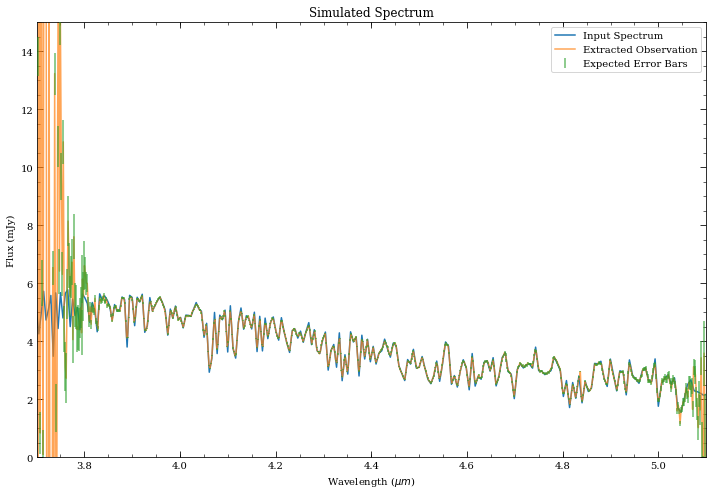

In [75]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(sp_M9V.wave/1e4, sp_M9V.flux, label='Input Spectrum')
ax.plot(wspec_rebin, spec_rebin_cal, alpha=0.7, label='Extracted Observation')
ax.errorbar(wspec_rebin, spec_rebin_cal, yerr=_spec_rebin_cal, zorder=3,
            fmt='none', label='Expected Error Bars', alpha=0.7)

ax.set_ylim([0,15])
ax.set_xlim([3.7,5.1])

ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_ylabel('Flux (mJy)')
ax.set_title('Simulated Spectrum')

ax.legend(loc='upper right');

## Example 4: Exoplanet Transit Spectroscopy

Let's say we want to observe an exoplanet transit using NIRCam grisms in the F322W2 filter. 

We assume a 2.1-hour transit duration for a K6V star (K=8.4 mag).

In [76]:
nrc = pynrc.NIRCam('F322W2', pupil='GRISM0', wind_mode='STRIPE', ypix=64)

In [77]:
# K6V star at K=8.4 mags
bp_k = S.ObsBandpass('k')
sp_K6V = pynrc.stellar_spectrum('K6V', 8.4, 'vegamag', bp_k)

In [78]:
# Constraints
well     = 0.5        # Keep well below 50% full
tacq     = 2.1*3600.  # 2.1 hour transit duration
ng_max   = 30         # Transit spectroscopy allows for up to 30 groups per integrations
nint_max = int(1e6)   # Effectively no limit on number of integrations

# Let's bin the spectrum to R~100
# dw_bin is a passable parameter for specifiying spectral bin sizes
R = 100
dw_bin = (nrc.bandpass.avgwave() / 10000) / R

In [79]:
res = nrc.ramp_optimize(sp_K6V, tacq_max=tacq, nint_max=nint_max, ng_max=ng_max, 
                        well_frac_max=well, dw_bin=dw_bin, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      23  480     15.33   7357.18   7523.19  30676.7    0.479  353.677
BRIGHT1      23  481     15.33   7372.50   7538.86  30708.6    0.479  353.677
BRIGHT1      23  482     15.33   7387.83   7554.54  30740.5    0.479  353.677
BRIGHT1      23  483     15.33   7403.16   7570.21  30772.4    0.479  353.677
BRIGHT1      23  484     15.33   7418.49   7585.88  30804.2    0.479  353.677
BRIGHT2      23  470     15.67   7363.99   7526.54  30381.0    0.490  350.190
BRIGHT2      23  471     15.67   7379.66   7542.56  30413.3    0.490  350.190
BRIGHT2      23  472     15.67   7395.32   7558.57  30445.5    0.490  350.190
BRIGHT2      23  473     15.67   7410.99   7574.58  30477.8    0.490  350.190
BRIGHT2      23  474     15.67   7426.66   7590.60  30510.0    0.490  350.

In [80]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        30  713     10.22   7285.65   7532.24  30342.1    0.319  349.609
RAPID        30  714     10.22   7295.87   7542.81  30363.4    0.319  349.609
BRIGHT1      23  480     15.33   7357.18   7523.19  30676.7    0.479  353.677
BRIGHT1      23  481     15.33   7372.50   7538.86  30708.6    0.479  353.677
BRIGHT2      23  470     15.67   7363.99   7526.54  30381.0    0.490  350.190
BRIGHT2      23  471     15.67   7379.66   7542.56  30413.3    0.490  350.190
SHALLOW2      9  514     14.31   7353.09   7530.86  30254.3    0.447  348.630
SHALLOW2      9  515     14.31   7367.39   7545.51  30283.7    0.447  348.630
SHALLOW4      9  491     14.99   7358.54   7528.36  29601.2    0.468  341.161
SHALLOW4      9  492     14.99   7373.53   7543.69  29631.4    0.468  341.161
MEDIUM2       5  514     14.31   7353.09   7530.86  30222.8    0

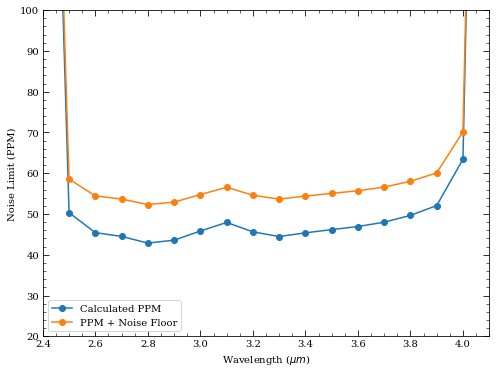

In [90]:
# Even though BRIGHT1 has a slight efficiency preference over RAPID 
# and BRIGHT2, we decide to choose RAPID, because we are convinced 
# that saving all data (and no coadding) is a better option. 
# If APT informs you that the data rates or total data shorage is 
# an issue, you can select one of the other options.

# Update to RAPID, ngroup=30, nint=716 and plot PPM
nrc.update_detectors(read_mode='RAPID', ngroup=30, nint=715)
snr_dict = nrc.sensitivity(sp=sp_K6V, dw_bin=dw_bin, forwardSNR=True, units='Jy')
wave = np.array(snr_dict['wave'])
snr  = np.array(snr_dict['snr'])

# Let assume bg subtraction of something with similar noise
snr /= np.sqrt(2.)
ppm = 1e6 / snr

# NOTE: We have up until now neglected to include a "noise floor"
# which represents the expected minimum achievable ppm from
# unknown systematics. To first order, this can be added in 
# quadrature to the calculated PPM.
noise_floor = 30 # in ppm
ppm_floor = np.sqrt(ppm**2 + noise_floor**2)

plt.plot(wave, ppm, marker='o', label='Calculated PPM')
plt.plot(wave, ppm_floor, marker='o', label='PPM + Noise Floor')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Noise Limit (PPM)')
plt.xlim([2.4,4.1])
plt.ylim([20,100])
plt.legend(loc=0)
plt.minorticks_on()

## Example 5: Extended Souce

Expect some faint galaxies of 25 ABMag/arcsec^2 in our field. What is the best we can do with 10,000 seconds of acquisition time? 

In [91]:
# Detection bandpass is F200W
nrc = pynrc.NIRCam('F200W')

# Flat spectrum (in photlam) with ABMag = 25 in the NIRCam bandpass
sp = pynrc.stellar_spectrum('flat', 25, 'abmag', nrc.bandpass)

In [92]:
res = nrc.ramp_optimize(sp, is_extended=True, tacq_max=10000, tacq_frac=0.05, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10    8   1052.20   8417.63   8503.53      9.8    0.000    0.106
MEDIUM8       9    9    944.84   8503.52   8600.16      9.8    0.000    0.106
MEDIUM8       9   10    944.84   9448.36   9555.73     10.4    0.000    0.106
MEDIUM8      10    9   1052.20   9469.83   9566.47     10.4    0.000    0.106
MEDIUM8       9   11    944.84  10393.19  10511.30     10.9    0.000    0.106
MEDIUM8      10   10   1052.20  10522.03  10629.41     11.0    0.000    0.106
DEEP8         8    5   1589.04   7945.21   7998.90      9.4    0.000    0.105
DEEP8         7    6   1374.31   8245.84   8310.27      9.6    0.000    0.105
MEDIUM8       8   11    837.47   9212.15   9330.26     10.2    0.000    0.105
DEEP8         6    8   1159.57   9276.57   9362.47     10.2    0.000    0.

In [93]:
# MEDIUM8 10 10 looks like a good option
nrc.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=10, verbose=True)

New Ramp Settings:
  read_mode :  MEDIUM8
  nf        :        8
  nd2       :        2
  ngroup    :       10
  nint      :       10
New Detector Settings
  wind_mode :     FULL
  xpix      :     2048
  ypix      :     2048
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :  107.368
  t_frame   :   10.737
  t_int     : 1052.203
  t_int_tot : 1062.940
  t_exp     : 10522.035
  t_acq     : 10629.408


In [94]:
# Calculate flux/mag for various nsigma detection limits
tbl = Table(names=('Sigma', 'Point (nJy)',    'Extended (nJy/asec^2)', 
                            'Point (AB Mag)', 'Extended (AB Mag/asec^2)'))
tbl['Sigma'].format = '.0f'
for k in tbl.keys()[1:]:
    tbl[k].format = '.2f'

for sig in [1,3,5,10]:
    snr_dict1 = nrc.sensitivity(nsig=sig, units='nJy', verbose=False)
    snr_dict2 = nrc.sensitivity(nsig=sig, units='abmag', verbose=False)
    tbl.add_row([sig, snr_dict1[0]['sensitivity'], snr_dict1[1]['sensitivity'],
                snr_dict2[0]['sensitivity'], snr_dict2[1]['sensitivity']])

In [96]:
tbl

Sigma,Source (nJy),Extended (nJy/asec^2),Source (AB Mag),Extended (AB Mag/asec^2)
float64,float64,float64,float64,float64
1,0.91,32.31,31.50,27.63
3,2.75,97.36,30.30,26.43
5,4.61,163.00,29.74,25.87
10,9.37,329.71,28.97,25.10
